Import needed libarires

In [1]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

import gc

Import Dataset

In [2]:
train = pd.read_csv("./Dataset/train.csv")

submission = pd.read_csv("./Dataset/sample_submission.csv")

# Analyze Dataset

In [3]:
print("Columns: ", list(train.columns))

#Deletes uneeded rows
train.drop(['discourse_id', 'essay_id'] , axis=1, inplace=True)

print("Null values: ", train.isnull().values.sum())
print("Duplicates in text row: ", train["discourse_text"].duplicated().values.sum())


Columns:  ['discourse_id', 'essay_id', 'discourse_text', 'discourse_type', 'discourse_effectiveness']
Null values:  0
Duplicates in text row:  74


Checks data imbalance in Discourse effectiveness

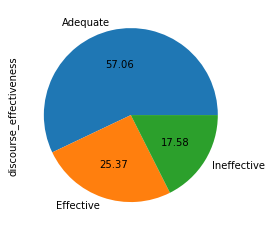

In [4]:
train['discourse_effectiveness'].value_counts().plot.pie(autopct='%.2f')

Checks data imbalance in discourse type

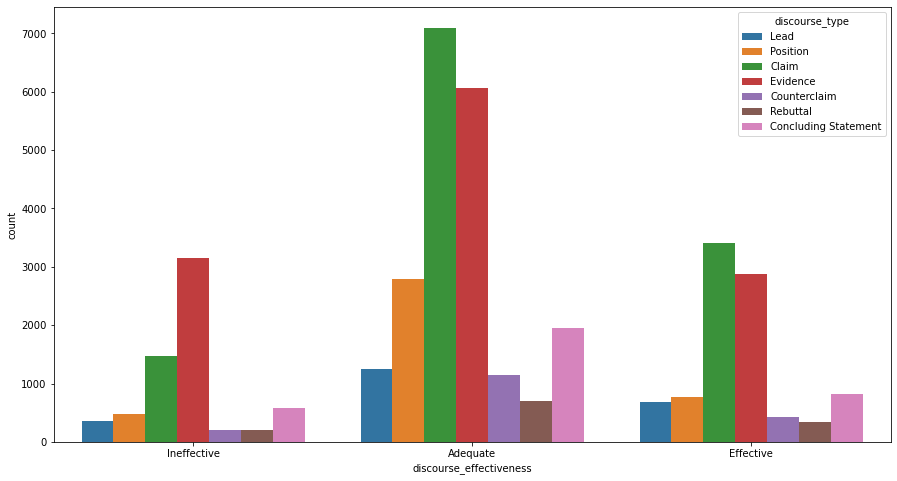

In [5]:
plt.subplots(1,1,figsize=(15,8))

sns.countplot(data=train,
              x="discourse_effectiveness",
              hue='discourse_type',
              order = ['Ineffective', 'Adequate', 'Effective']
             )

plt.show()

Word Cloud for each Discourse effectiveness

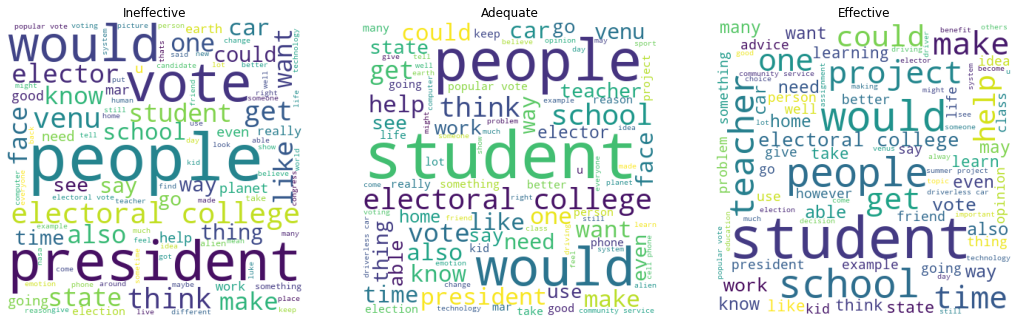

In [6]:
plt.subplots(nrows=1, ncols=3, figsize=(18,8))


textArr = {
    "Ineffective": train.loc[train['discourse_effectiveness']=='Ineffective', 'discourse_text'],
    "Adequate": train.loc[train['discourse_effectiveness']=='Adequate', 'discourse_text'],
    "Effective": train.loc[train['discourse_effectiveness']=='Effective', 'discourse_text']
}

figIndex= 1

for effectiveness, texts in textArr.items():
    for i, x in texts.iteritems():
        texts[i] = x.lower() 
    
    allText = " ".join(texts) + " "
    
    plt.subplot(1,3,figIndex).set_title(effectiveness)
    plt.plot()
    wordCloud = WordCloud(width = 400, height = 400,
            background_color ='white',
            stopwords = set(stopwords.words('english')),
            min_font_size = 10).generate(allText)
    plt.imshow(wordCloud)
    plt.axis('off')
    
    figIndex +=1
        

plt.show()    

# Pre Processing

Orinially encodes effectiveness

In [7]:
# ordinally encodes effectivness
train['discourse_effectiveness'] = train["discourse_effectiveness"].replace(
            {"Ineffective": 0, "Adequate": 1, "Effective": 2}
        )

Cleans the text

In [8]:
# ########## Clean data
def cleanText(df):

    stopWords = set(stopwords.words('english'))
    stemmer = PorterStemmer()

    for index, row in df.iterrows():

        curText = row.discourse_text

        # lower case conversion
        curText = curText.lower()
        # removes all the trailing and leading spaces
        curText = curText.strip()
        
        # Keeping stopwords increased accuracy
        
        #Removes stop words
        #def remove_stop(x):
        #    return " ".join([word for word in str(x).split() if word not in stopWords])
        #curText = remove_stop(curText)
        
        # removing all non alphabetic char
        curText = re.sub(r'[^a-z ]+', '', curText)
        # stems the text
        curText = stemmer.stem(curText)
        # removing multiple spaces in a row
        curText = re.sub(r'(\s)+', ' ', curText)
        # replaces the text
        df.at[index, 'discourse_text'] = curText


cleanText(train)

print(train['discourse_text'])

print("\nCleaned Train Dataset")

0        hi im isaac im going to be writing about how t...
1        on my perspective i think that the face is a n...
2        i think that the face is a natural landform be...
3        if life was on mars we would know by now the r...
4        people thought that the face was formed by ali...
                               ...                        
36760    for many people they dont like only asking one...
36761    also people have different views and opinions ...
36762    advice is something that can impact a persons ...
36763    someone can use everything that many people sa...
36764    in conclusion asking for an opinion can be ben...
Name: discourse_text, Length: 36765, dtype: object

Cleaned Train Dataset


Vectorizes the cleaned text

In [9]:
# Vectorized strings
countVec = TfidfVectorizer(
    min_df=3
)

# Fits the vectorized with train data
train_vectors = countVec.fit_transform(train['discourse_text'])

# Gets a list of all the words in the vector
vector_features = countVec.get_feature_names_out()
#print("Vector features: ", vector_features)  # Prints all the words fit intoz the in the vectorizer
print("Feature Counts: ", len(vector_features), "\n\n")  # Prints the amount of words in the vectorizer
# Converts the vectorized data matrix to array
train_vec_arr = train_vectors.toarray()
# Puts the vectorized data into the dataframe
    #train_vec_dataframe = pd.DataFrame(data=train_vec_arr, columns=vector_features)
train = pd.concat([train, pd.DataFrame(data=train_vec_arr, columns=vector_features).reset_index(drop=True)], axis=1)


del train_vectors
del train_vec_arr
gc.collect()

Feature Counts:  10234 




MemoryError: Unable to allocate 2.80 GiB for an array with shape (36765, 10234) and data type float64

One Hot Encondes the discourse type row

In [ ]:
# One hot encodes discourse type
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_categorical_OneHot_train = pd.DataFrame(OH_encoder.fit_transform(train[['discourse_type']]))
print("One hot enconded train dataset")

Combines the Dataset

In [ ]:
def combineDataFrame(df, restDfs):
    # drops the text column as it has been vectorized and type since it's been one hot encoded
    df.drop(['discourse_text', 'discourse_type'], inplace=True, axis=1)
    #resets index to make concat work
    df.reset_index(drop=True, inplace=True)
    for curDf in restDfs:
        #resets index to make concat work
        curDf.reset_index(drop=True, inplace=True)
        df = pd.concat([df, curDf], axis=1)
    
    return df

# Gets the Qcombined and fully cleaned model
train = combineDataFrame(train, [X_categorical_OneHot_train])
print("Fully Combined the Train dataset")

Performs Oversampling on Train dataset

In [ ]:
#Gets the y value
yFinished = train['discourse_effectiveness']
#drops the y value
train.drop('discourse_effectiveness', axis=1, inplace=True)

# Performs oversampling with a 1-1 ratio

#smote = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
ros = RandomOverSampler(sampling_strategy='auto',random_state=42)
train, yFinished = ros.fit_resample(train, yFinished)
print("Over Sampling on data")

Train Test split to make Validation set

In [ ]:
XTrain, XValid, yTrain, yValid = train_test_split(train, yFinished, test_size=0.2, random_state=42) 

del train
gc.collect()

print("Split into train and validation")

# ***Models Section***

**Model Imports**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from xgboost import XGBRegressor

Model Selection

In [ ]:
Models = {
    "LogisticReg": LogisticRegression(C=1, max_iter=500, multi_class="multinomial")
    #"SDGCLassifer": SGDClassifier(loss='log_loss', max_iter=10000, alpha=0.00001)
    }

modelsTrained = {}

for modelName, model in Models.items():

    fitModel = model.fit(XTrain, yTrain)
    
    trainPred = fitModel.predict(XTrain)
    trainMeanError = accuracy_score(trainPred, yTrain)
    print(modelName, " Train Accuracy: ", trainMeanError)
    trainConfusionMatrix = confusion_matrix(trainPred, yTrain)
    print(trainConfusionMatrix)

    validPred = fitModel.predict(XValid)
    validMeanError = accuracy_score(validPred, yValid)
    print(modelName, " Valid Accuracy: ", validMeanError)
    validConfusionMatrix = confusion_matrix(validPred, yValid)
    
    labels = [ 'Ineffective', "Adequate", "Effective"]
    
    heatMapData = pd.DataFrame(validConfusionMatrix, index=labels, columns=labels)
    
    dataSum = heatMapData.sum(axis = 1)
    
    ineffectivePerc = heatMapData.at['Ineffective','Ineffective'] / dataSum['Ineffective']
    adequatePerc = heatMapData.at['Adequate','Adequate'] / dataSum['Adequate'] 
    effectivePerc = heatMapData.at['Effective','Effective'] / dataSum['Effective']  
    
    print("Ineffective Accuracy: ", ineffectivePerc)
    print("Adequate Accuracy: ", adequatePerc)
    print("Effective Accuracy: ", effectivePerc)
    
    sns.heatmap(heatMapData, annot = True, fmt = 'd')
    plt.title('Confusion matrix')
    plt.xlabel('PRED')
    plt.ylabel('REAL')
    plt.show()
    #Saves the fit model
    modelsTrained[modelName] = fitModel

Clears Train data memory

In [ ]:
del XTrain
del XValid
del yTrain
del yValid

gc.collect()

Setting up test dataset

In [ ]:
test = pd.read_csv("./Dataset/test.csv")

testID = test['discourse_id']

test.drop(['discourse_id', 'essay_id'] , axis=1, inplace=True)
cleanText(test)

test_vectors = countVec.transform(test['discourse_text'])
test_vec_arr = test_vectors.toarray()
    #test_vec_dataframe = pd.DataFrame(data=test_vec_arr, columns=vector_features)
test = pd.concat([test, pd.DataFrame(data=test_vec_arr, columns=vector_features).reset_index(drop=True)], axis=1)

del test_vectors
del test_vec_arr
gc.collect()

X_categorical_OneHot_test = pd.DataFrame(OH_encoder.transform(test[['discourse_type']]))
test = combineDataFrame(test, [X_categorical_OneHot_test])

**Exporing Submission**

In [ ]:
testPred = modelsTrained['LogisticReg'].predict_proba(test)

submission.loc[:, "discourse_id"] =testID
submission.loc[:,"Ineffective"] = testPred[:,0]
submission.loc[:,"Adequate"] = testPred[:,1]
submission.loc[:,"Effective"] = testPred[:,2]

submission

In [ ]:
submission.to_csv('submission.csv',index=None)